In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

**Load Admission**

In [25]:
adm = pd.read_csv('/content/sample_data/ADMISSIONS.csv')

adm = adm.sort_values(['SUBJECT_ID','ADMITTIME'])
adm = adm.reset_index(drop = True)
adm['NEXT_ADMITTIME'] = adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)

adm['NEXT_ADMISSION_TYPE'] = adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)
rows = adm.NEXT_ADMISSION_TYPE == 'ELECTIVE' #elective are unplanned admissions
adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN
adm = adm.sort_values(['SUBJECT_ID','ADMITTIME'])

adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')
adm['DAYS_NEXT_ADMIT']=  (adm.NEXT_ADMITTIME - adm.DISCHTIME).dt.total_seconds()/(24*60*60)

**Load Notes**

In [ ]:
notes = pd.read_csv("/content/drive/MyDrive/NOTEEVENTS.csv")

In [27]:
notes_dis_sum = notes.loc[df_notes.CATEGORY == 'Discharge summary']
notes_dis_sum_last = (notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()

**Merge**

In [28]:
adm_notes = pd.merge(adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')

In [29]:
adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

In [30]:
clean = adm_notes.loc[adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [31]:
clean['OUTPUT_LABEL'] = (clean.DAYS_NEXT_ADMIT < 30).astype('int')

**Make a test/train split of the data**

In [32]:
clean = clean.sample(n = len(clean), random_state = 42)
clean = clean.reset_index(drop = True)
test=clean.sample(frac=0.30,random_state=42)
test = test.sample(frac = 0.5, random_state = 42)
valid = test.drop(test.index)
train_all=clean.drop(test.index)

In [33]:
rows_pos = train_all.OUTPUT_LABEL == 1
pos = train_all.loc[rows_pos]
neg = train_all.loc[~rows_pos]
train = pd.concat([pos,neg.sample(n = len(pos), random_state = 42)],axis = 0)
train = train.sample(n = len(train), random_state = 42).reset_index(drop = True)

In [ ]:
df_train.TEXT = df_train.TEXT.fillna(' ')
df_valid.TEXT = df_valid.TEXT.fillna(' ')
df_train.TEXT = df_train.TEXT.str.replace('\n',' ')
df_valid.TEXT = df_valid.TEXT.str.replace('\n',' ')
df_train.TEXT = df_train.TEXT.str.replace('\r',' ')
df_valid.TEXT = df_valid.TEXT.str.replace('\r',' ')

def tokenize(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

vect = CountVectorizer(tokenizer = tokenize)
vect.fit(sample_text)
X = vect.transform(sample_text)
X.toarray()
vect.get_feature_names()
vect = CountVectorizer(max_features = 3000, tokenizer = tokenize)
vect.fit(df_train.TEXT.values)

**Use your machine learning algorithm to learn from your training set**

In [ ]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenize, 
                       stop_words = my_stop_words)

vect.fit(df_train.TEXT.values)
X_train = vect.transform(df_train.TEXT.values)
X_valid = vect.transform(df_valid.TEXT.values)
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train, y_train)
model = clf
train_preds = model.predict_proba(X_train)[:,1]
valid_preds = model.predict_proba(X_valid)[:,1]

In [36]:
print(y_train[15:23].values)
print(train_preds[15:23])

[1 1 1 1 1 1 1 1]
[0.60876019 0.7018346  0.82441754 0.55267982 0.4572866  0.66855654
 0.43075838 0.9404186 ]


**Evaluate the model with the test set**

In [37]:
df_test.TEXT = df_test.TEXT.fillna(' ')
df_test.TEXT = df_test.TEXT.str.replace('\n',' ')
df_test.TEXT = df_test.TEXT.str.replace('\r',' ')
X_test = vect.transform(df_test.TEXT.values)
y_test = df_test.OUTPUT_LABEL
test_preds = model.predict_proba(X_test)[:,1]

In [39]:
print(y_test[15:23].values)
print(test_preds[15:23])

[0 0 0 0 0 0 0 0]
[0.50079379 0.42833089 0.71550406 0.40346128 0.38753352 0.55039571
 0.50421008 0.57326816]


Train Area Under Curve:0.754
Valid Area Under Curve:0.706
Train accuracy:0.685
Valid accuracy:0.714


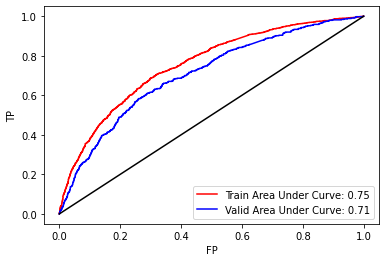

In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, valid_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train Area Under Curve:%.3f'%auc_train)
print('Valid Area Under Curve:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, valid_preds, thresh))
